## What Will Be Covered

- Transfer Learning
- TensorFlow Hub
- Multi-Class Convolutional Neural Networks
- Downloading & Processing Data
- Activation
- Pooling
- Optimizing Performance
- Minimizing Overfitting
- Augmenting Images
- ResNet
- EfficientNet
- Much More!

## Multi-Class Convolutional Neural Network

Creating Models that can identify objects in images. This time I create a model that can tell the difference between 10 different types of food.

## Process

- Collect many images of like size
- Split images into training & test sets
- Discover potential labels / features
- Flatten image into a tensor
- Increase hidden units : Add weightings to get desired output
- Try different activation functions : Helps decide what data is most important
- Try different optimization functions : Optimize by smoothing data to expected results
- Increase learning rate : How much to change the model based on estimated error
- Fit longer : Increase the number of times we try to fit the data

## Using GPU with Google Colab

If execution takes a long time turn on the GPU on Google colab.

- Runtime -> Change Runtime Type -> GPU

In [96]:
# What GPU are we using?
!nvidia-smi

Thu Jun  2 16:56:31 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:0A:00.0  On |                  N/A |
|  0%   35C    P8    36W / 350W |  24001MiB / 24576MiB |     16%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Imports

In [97]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

# Used to build and deploy machine learning apps
import tensorflow as tf

# Deep Learning API for creating Neural Networks (Runs on TensorFlow)
from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow import math
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Activation
from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Scikit-learn : machine learning library
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

# Used for accessing files and file names
import pathlib 
import os
import zipfile

## Download Data

I'll be using the food dataset from Kaggle
https://www.kaggle.com/datasets/kmader/food41

You can either put your images folder in the same directory as this file, or use Google Drive or other online storage options with Google Colab.

- I zipped my images folder
- Uploaded the zipped file to Google Drive in a folder called data
- Mount the drive as I show next
- Unzip files

I split up images into training and test folders with a separate folder for hotdog and pizza in each 800 of each in training and 200 in test

## Mount Google Drive & Unzip Files

In [98]:
# from google.colab import drive
# drive.mount('/content/gdrive')

In [99]:
# Unzip the files
# my_files = zipfile.ZipFile("/content/gdrive/MyDrive/data/food_imgs.zip")
# my_files.extractall()
# my_files.close()

## Analyze the Files

In [100]:
# Function grabs a random image from a directory
def display_random_image(dir, class_type):
    # Define directory to look in
    img_dir = dir + "/" + class_type
    
    # Get files from directory
    files = os.listdir(img_dir)
    
    # Pick a random image from that directory
    img_name = random.choice(files)
    
    # Read in the image
    img = mpimg.imread(img_dir + "/" + img_name)
    
    # Plot image with title & shape
    plt.imshow(img)
    plt.title(class_type)
    plt.axis("off");
    
    # Show the shape of the image
    print(f"Image shape: {img.shape}") 

    # So we can see how the computer sees the image
    # The image is understood as a big tensor with each pixel being
    # represented with RGB color amounts between 0 & 255
    # return img

Image shape: (256, 512, 3)


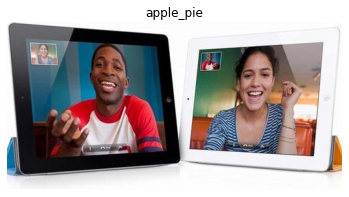

In [101]:
# Show random Apple Pie
display_random_image("food_imgs/train/",
                    "apple_pie")

Image shape: (512, 512, 3)


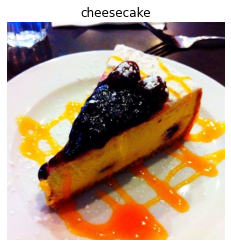

In [102]:
# Show random Cheesecake
display_random_image("food_imgs/train/",
                    "cheesecake")

Image shape: (340, 512, 3)


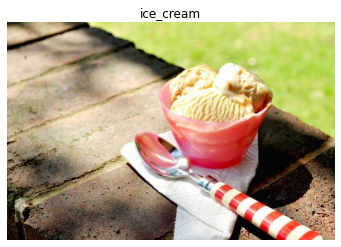

In [103]:
# Show random Ice Cream
display_random_image("food_imgs/train/",
                    "ice_cream")

This is a fantastic site for understanding CNNs 
https://poloclub.github.io/cnn-explainer/

## Each Layer of the Network

- Input Layer : Has 3 channels represented by RGB channels
- Convolutional Layer : Weights extract features that differentiate images
- Activation ReLU : Used to produce non-linear decision boundaries
- Pooling Layer : Summarizes feature maps
- Flatten Layer : Converts a 3D layer into a 1D vector
- Activation Softmax : Softmax is used to scale from multiple tensors into output probabilities

## Understanding Hyperparameters

**Filter :** moves across the image starting in the upper left and proceeds left to right and top to bottom 1 pixel at a time.

**Stride :** refers to the amount of movement between applications of a filter to the input image. This stride is almost always the same movement amount horizontally as well as vertically. You can see that applying a stride will also cause the output feature map to be smaller than the original.

**Pooling :** provides a summarized version of the features detected in the input. They are used so that small changes in the location of a feature in the input will result in a pooled feature map in the same location. Pooling often helps in situations in which your model overfits (Training Accuracy is Rising / Testing Accuracy is Falling). 

Pooling does this by enlarging important features while disregarding very small details which if studied can cause over fitting.

## Prepare Data

In [104]:
# Setup train & test directories
train_dir = "food_imgs/train/"
validation_dir = "food_imgs/test/"

In [105]:
# Normalize from 0 to 255 to 0 to 1 
train_IDG = ImageDataGenerator(rescale=1/255)
validation_IDG = ImageDataGenerator(rescale=1/255)

# Load data and turn it into batches
train_data = train_IDG.flow_from_directory(train_dir,
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode="categorical") # Multi-class instead of binary

val_data = validation_IDG.flow_from_directory(validation_dir,
                                                target_size=(256, 256),
                                                batch_size=32,
                                                class_mode="categorical")

Found 16000 images belonging to 20 classes.
Found 4000 images belonging to 20 classes.


## Prepare Multi-class CNN Model

In [106]:
# Get the total number of batches of 32 images
len(train_data), 16000/32

(500, 500.0)

In [108]:
# Create model
model_1 = Sequential([
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(20),
    Activation(activation="softmax") # 20 output neurons
])

# Compile model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_1 = model_1.fit(train_data, # 20 classes
                        epochs=5,
                        steps_per_epoch=len(train_data), # Take enough steps to go through all batches
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
500/500 [==============================] - 98s 195ms/step - loss: 2.8273 - accuracy: 0.1367 - val_loss: 2.6587 - val_accuracy: 0.1995
Epoch 2/5
500/500 [==============================] - 38s 77ms/step - loss: 2.5689 - accuracy: 0.2267 - val_loss: 2.5288 - val_accuracy: 0.2310
Epoch 3/5
500/500 [==============================] - 38s 76ms/step - loss: 2.1352 - accuracy: 0.3606 - val_loss: 2.6572 - val_accuracy: 0.2122
Epoch 4/5
500/500 [==============================] - 38s 77ms/step - loss: 1.1616 - accuracy: 0.6538 - val_loss: 3.4643 - val_accuracy: 0.1820
Epoch 5/5
500/500 [==============================] - 38s 76ms/step - loss: 0.3711 - accuracy: 0.8944 - val_loss: 5.8643 - val_accuracy: 0.1552


The accuracy looks very bad, but actually if we have 20 classes 100 / 20 = 5, so it is 3X better than pure guessing. 

In [109]:
model_1.evaluate(val_data)

125/125 [==============================] - 85s 686ms/step - loss: 5.8643 - accuracy: 0.1552


[5.864256858825684, 0.15524999797344208]

<AxesSubplot:>

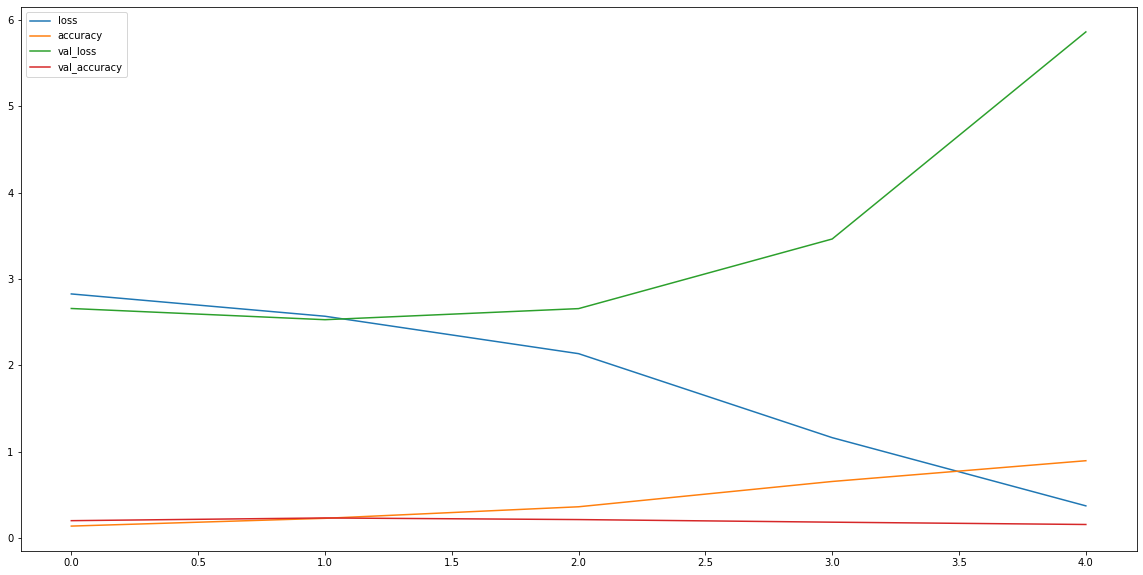

In [110]:
# Plot loss and accuracy
pd.DataFrame(history_1.history).plot(figsize=(20, 10))

Validation loss is increasing which means our model is overfitting. We can try to fix that.

## Review Conv2D

- Filters : How many filters should pass over input (Typical : 10, 32, 64, 128) More filters = more complex model
- Kernel Size : Defines how big filters are (Typical : 3x3, 5x5, 7x7) Lower Values = Smaller Features / High Values = Larger features
- Padding : If marked same it adds padding so output shape is the same as input shape (If valid output shrinks)
- Strides : Number of steps the filters take while moving across an image (Typical 1 or 2)

The kernel has a defined size with the same height and width in pixels. The kernel slides across the image while performing element wise multiplication using adjusted weightings. Kernel weights start off as random values. The goal is to find edges and features that can be used to make predictions on what objects are in an image. Different features will be found in the different color channels.

Stride defines how many pixels the kernel moves between calculations. If images aren't complex you may be able to set stride to 2. 

Padding makes sure the output feature map is the same size as the input image if assigned "same". If assigned "valid" then the output shape is compressed. It does this by adding padding around the image to make sure each pixel has the opportunity to be in the center of the kernel when calculations are performed.

Activation functions help our network decide what is important data. They receive data and add weightings to it and pass the results to other hidden layers. Depending on the error value the weights are updated

## Augmentation

Increasing the amount of data by adding slightly modified versions of existing data. Images are rotated, cropped, sheared, zoomed, flipped, etc.

In [111]:
# Augmenting this data doesn't change the images, but instead 
# loads here when executed

data_augmentation = Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [112]:
# Create model
model_2 = Sequential([
    data_augmentation,
    Conv2D(10,3,input_shape=(256,256,3)),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Conv2D(10,3),
    Activation(activation="relu"),
    Conv2D(10,3),
    Activation(activation="relu"),
    MaxPool2D(),
    Flatten(),
    Dense(20),
    Activation(activation="softmax") # 20 output neurons
])

# Compile model
model_2.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# Fit the model
history_2 = model_2.fit(train_data, # 20 classes
                        epochs=5,
                        steps_per_epoch=len(train_data), # Take enough steps to go through all batches
                        validation_data=val_data,
                        validation_steps=len(val_data))

Epoch 1/5
500/500 [==============================] - 96s 191ms/step - loss: 2.8749 - accuracy: 0.1058 - val_loss: 2.7626 - val_accuracy: 0.1343
Epoch 2/5
500/500 [==============================] - 40s 81ms/step - loss: 2.7515 - accuracy: 0.1514 - val_loss: 2.8207 - val_accuracy: 0.1635
Epoch 3/5
500/500 [==============================] - 41s 81ms/step - loss: 2.6404 - accuracy: 0.1928 - val_loss: 2.9586 - val_accuracy: 0.1737
Epoch 4/5
500/500 [==============================] - 41s 81ms/step - loss: 2.5152 - accuracy: 0.2348 - val_loss: 2.6563 - val_accuracy: 0.2132
Epoch 5/5
500/500 [==============================] - 41s 82ms/step - loss: 2.4393 - accuracy: 0.2553 - val_loss: 2.5946 - val_accuracy: 0.2407


<AxesSubplot:>

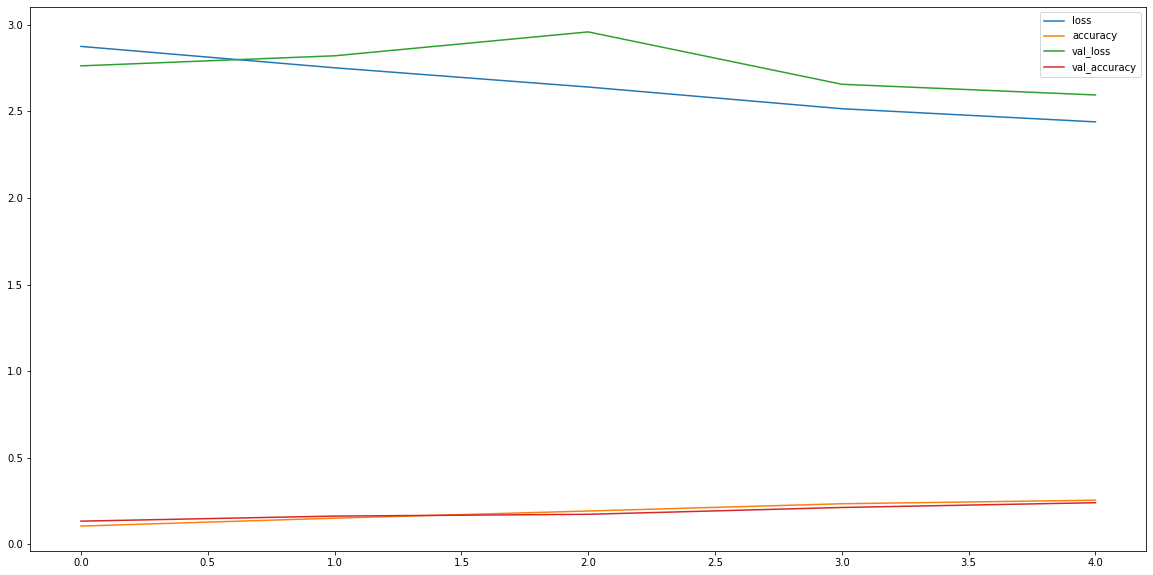

In [113]:
# Plot loss and accuracy
pd.DataFrame(history_2.history).plot(figsize=(20, 10))

5X accuracy now and overfitting seems to be handled, but accuracy isn't high enough. 

In [1]:
# Get class names
class_names = os.listdir('food_imgs/train/')
class_names.sort()
class_names

['apple_pie',
 'breakfast_burrito',
 'caesar_salad',
 'cheese_plate',
 'cheesecake',
 'chicken_quesadilla',
 'chicken_wings',
 'club_sandwich',
 'cup_cakes',
 'donuts',
 'falafel',
 'fish_and_chips',
 'french_fries',
 'hamburger',
 'hot_dog',
 'ice_cream',
 'pizza',
 'ramen',
 'steak',
 'sushi']

## Make Predictions on Outside Images

(-0.5, 255.5, 255.5, -0.5)

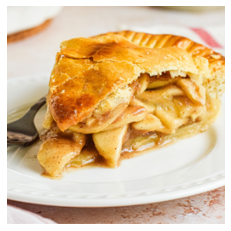

In [115]:
# With Google colab
# apple_pie = mpimg.imread("/content/gdrive/MyDrive/data/apple_pie.png")

# Used on your computer
apple_pie = mpimg.imread("apple_pie.png")
plt.imshow(apple_pie)
plt.axis(False)

In [116]:
apple_pie.shape

(256, 256, 3)

## Normalize & Resize

In [117]:
def normalize_and_resize(img_loc):
    # With Google Colab
    # my_img = tf.io.read_file(img_loc)

    # Read in image
    my_img = tf.io.read_file(img_loc)

    # Turn file into a tensor
    my_img = tf.image.decode_image(my_img)

    # Resize image
    my_img = tf.image.resize(my_img, size=[256, 256])

    # Normalize data
    my_img = my_img / 255

    return my_img

In [118]:
apple_pie = normalize_and_resize("/content/gdrive/MyDrive/data/apple_pie.png")
apple_pie

<tf.Tensor: shape=(256, 256, 3), dtype=float32, numpy=
array([[[0.8862745 , 0.8745098 , 0.84313726],
        [0.8901961 , 0.8745098 , 0.84313726],
        [0.89411765, 0.88235295, 0.8509804 ],
        ...,
        [0.8235294 , 0.7647059 , 0.6431373 ],
        [0.81960785, 0.7607843 , 0.63529414],
        [0.8235294 , 0.77254903, 0.6509804 ]],

       [[0.8980392 , 0.89411765, 0.8745098 ],
        [0.90588236, 0.8980392 , 0.8745098 ],
        [0.90588236, 0.8980392 , 0.8745098 ],
        ...,
        [0.8156863 , 0.75686276, 0.6313726 ],
        [0.8117647 , 0.75686276, 0.62352943],
        [0.8156863 , 0.7647059 , 0.63529414]],

       [[0.90588236, 0.9019608 , 0.88235295],
        [0.90588236, 0.9019608 , 0.88235295],
        [0.90588236, 0.9019608 , 0.88235295],
        ...,
        [0.8039216 , 0.7529412 , 0.62352943],
        [0.8156863 , 0.7647059 , 0.6392157 ],
        [0.827451  , 0.76862746, 0.65882355]],

       ...,

       [[0.9019608 , 0.8862745 , 0.8901961 ],
        [0.90

In [119]:
# Tells us how likely the image belongs to a class in our model
prediction = model_2.predict(tf.expand_dims(apple_pie, axis=0))
prediction

array([[0.09349842, 0.0167603 , 0.00628631, 0.00856998, 0.03533958,
        0.06919891, 0.08136798, 0.0423747 , 0.00387072, 0.02574597,
        0.00491595, 0.10173463, 0.01658262, 0.05796509, 0.12457582,
        0.00369202, 0.07476397, 0.16572867, 0.03279136, 0.03423704]],
      dtype=float32)

In [126]:
# Get prediction by getting the largest percentage 
# in the Numpy array
class_names[np.argmax(prediction)]

'ramen'

## Try with Pizza Image

In [127]:
# With Google colab
# pizza = mpimg.imread("/content/gdrive/MyDrive/data/my_pizza.jpg")

# Used on your computer
pizza = normalize_and_resize(/content/gdrive/MyDrive/data/my_pizza.jpg)
prediction = model_2.predict(tf.expand_dims(pizza, axis=0))
class_names[np.argmax(prediction)]

'pizza'

## Try with Chicken Wings

In [128]:
# With Google colab
# wings = mpimg.imread("/content/gdrive/MyDrive/data/chicken_wings.png")

# Used on your computer
wings = normalize_and_resize("chicken_wings.png")
prediction = model_2.predict(tf.expand_dims(wings, axis=0))
class_names[np.argmax(prediction)]

'pizza'

Are results weren't very good. Let's see if we can get better results with Transfer Learning?

## What is Transfer Learning?

Transfer learning occurs when you take a model trained to perform a certain task and reuse it to perform another task. Often enormous resources are required to train a model to do a sophisticated task. If you can find a model that was trained on a related task you can cut your development time. 

In [129]:
import tensorflow_hub as hub # Provides pretrained models

# pip install tensorboard==2.8.0

## Explore TensorFlow Hub for Pretrained Models

https://www.tensorflow.org/hub provides many trained machine learning models. Find pretrained models here TFHub.dev. TensorFlow Hub allows you to use pretrained models by referencing a URL.

- Click Image on the left
- Problem domain : Image classification, Image feature vector
- TF Version : TF2
- Architecture : EfficientNet V2 & ResNet V2 50
- imagenet/resnet_v2_50/feature_vector
- efficientnet/b7/feature-vector

## Build ResNet Feature Model

In [133]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/5"
# Download ResNet model and save as Keras layer
# Trainable : False means we don't want to train it further
resnet_layer = hub.KerasLayer(resnet_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
resnet_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    resnet_layer,
    # Define we will use 20 classes
    Dense(20,
        activation="softmax")
])

In [134]:
resnet_model.summary()

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_3 (KerasLayer)  (None, 2048)              23564800  
                                                                 
 dense_18 (Dense)            (None, 20)                40980     
                                                                 
Total params: 23,605,780
Trainable params: 40,980
Non-trainable params: 23,564,800
_________________________________________________________________


In [135]:
# Compile resnet Model
resnet_model.compile(loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [136]:
# Fit Transfer Learning Model
resnet_history = resnet_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data)

Epoch 1/5
500/500 [==============================] - 128s 248ms/step - loss: 1.0992 - accuracy: 0.6776 - val_loss: 0.8151 - val_accuracy: 0.7613
Epoch 2/5
500/500 [==============================] - 69s 139ms/step - loss: 0.6823 - accuracy: 0.7977 - val_loss: 0.7677 - val_accuracy: 0.7728
Epoch 3/5
500/500 [==============================] - 72s 145ms/step - loss: 0.5656 - accuracy: 0.8322 - val_loss: 0.7486 - val_accuracy: 0.7845
Epoch 4/5
500/500 [==============================] - 79s 157ms/step - loss: 0.4853 - accuracy: 0.8551 - val_loss: 0.7610 - val_accuracy: 0.7772
Epoch 5/5
500/500 [==============================] - 76s 153ms/step - loss: 0.4294 - accuracy: 0.8712 - val_loss: 0.7589 - val_accuracy: 0.7837


## Can ResNet Recognize Pizza? 

In [137]:
my_pizza = normalize_and_resize("/content/gdrive/MyDrive/data/my_pizza.jpg")
prediction = resnet_model.predict(tf.expand_dims(my_pizza, axis=0))
class_names[np.argmax(prediction)]

'pizza'

## Can ResNet Recognize Chicken Wings?

In [138]:
my_wings = normalize_and_resize("/content/gdrive/MyDrive/data/chicken_wings.png")
prediction = resnet_model.predict(tf.expand_dims(my_wings, axis=0))
class_names[np.argmax(prediction)]

'chicken_wings'

## Can ResNet Recognize Apple Pie?

In [139]:
my_pie = normalize_and_resize("/content/gdrive/MyDrive/data/apple_pie.png")
prediction = resnet_model.predict(tf.expand_dims(my_pie, axis=0))
class_names[np.argmax(prediction)]

'apple_pie'

ResNet recognized all 3 with a 3X accuracy versus our original Model 2!

## Build Efficient Net Feature Model

In [140]:
eff_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"
# Download EfficientNet model and save as Keras layer
# Trainable : False means we don't want to train it further
eff_layer = hub.KerasLayer(eff_url,
                            trainable=False,
                            input_shape=(256,256,3))

# Create model
eff_model=tf.keras.Sequential([
    # Puts images through downloaded model first
    eff_layer,
    # Define we will use 20 classes
    Dense(20,
        activation="softmax")
])

In [141]:
# Compile EfficientNet Model
eff_model.compile(loss="categorical_crossentropy",
optimizer=tf.keras.optimizers.Adam(),
metrics=["accuracy"])

In [142]:
# Fit Transfer Learning Model
eff_history = eff_model.fit(train_data,
                                epochs=5,
                                steps_per_epoch=len(train_data),
                                validation_data=val_data)

Epoch 1/5
500/500 [==============================] - 344s 646ms/step - loss: 0.8388 - accuracy: 0.7684 - val_loss: 0.6112 - val_accuracy: 0.8205
Epoch 2/5
500/500 [==============================] - 550s 1s/step - loss: 0.5222 - accuracy: 0.8446 - val_loss: 0.5534 - val_accuracy: 0.8342
Epoch 3/5
500/500 [==============================] - 323s 647ms/step - loss: 0.4426 - accuracy: 0.8703 - val_loss: 0.5311 - val_accuracy: 0.8407
Epoch 4/5
500/500 [==============================] - 320s 640ms/step - loss: 0.3903 - accuracy: 0.8851 - val_loss: 0.5318 - val_accuracy: 0.8413
Epoch 5/5
500/500 [==============================] - 326s 652ms/step - loss: 0.3486 - accuracy: 0.8992 - val_loss: 0.5235 - val_accuracy: 0.8405


## Can EfficientNet Recognize Pizza?

In [ ]:
prediction = eff_model.predict(tf.expand_dims(my_pizza, axis=0))
class_names[np.argmax(prediction)]

## Chicken Wings?

In [ ]:
prediction = eff_model.predict(tf.expand_dims(wings, axis=0))
class_names[np.argmax(prediction)]

## Apple Pie?

In [ ]:
prediction = eff_model.predict(tf.expand_dims(apple_pie, axis=0))
class_names[np.argmax(prediction)]